# <font style = "color:rgb(50,120,229)">Feature Matching </font>
Once we have found good features ( like ORB ) in an image, we can use them to accomplish various computer vision tasks by matching features in different images. Think of these features as the DNA of the image.

In this module, we will see how to match features in one image with others using the different algorithms. here are 3 types of feature matching methods available in OpenCV:
1. **Brute-Force matcher**
1. **Descriptor Matcher**
1. **FLANN Matcher** 

## <font style = "color:rgb(50,120,229)">Compute ORB Descriptors</font>

Here, we will see a simple example on how to match features between two images.

We are using ORB descriptors to match features. So let's start with loading images and finding descriptors.

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [16]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [17]:
img1 = cv2.imread("data/images/book.jpeg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("data/images/book_scene.jpeg", cv2.IMREAD_GRAYSCALE)

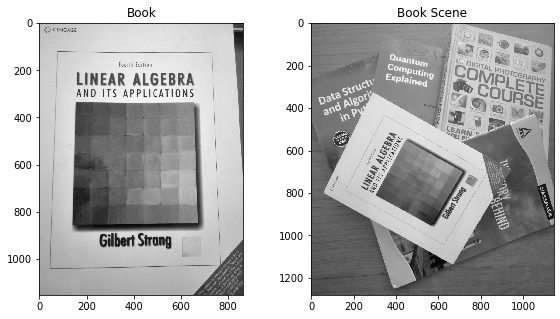

In [18]:
plt.figure(figsize=[20,5])
plt.subplot(141);plt.imshow(img1, cmap = 'gray');plt.title("Book");
plt.subplot(142);plt.imshow(img2, cmap = 'gray');plt.title("Book Scene");


In [19]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# <font style="color:rgb(50,120,229)">Brute Force Matcher </font>

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

For BF matcher, first we have to create the BFMatcher object using [**`cv2.BFMatcher()`**](https://docs.opencv.org/4.1.0/d3/da1/classcv_1_1BFMatcher.html). 

### <font style="color:rgb(8,133,37)">Function Syntax </font>
#### <font style = "color:rgb(8,133,37)">1. Create Matcher object </font>

```python
retval	=	cv2.BFMatcher_create(	[, normType[, crossCheck]]	)

or

retval	=	cv2.BFMatcher()
```
It takes two optional params. 
- `normType`. It specifies the distance measurement to be used. By default, it is [`cv2.NORM_L2`](https://docs.opencv.org/4.1.0/d2/de8/group__core__array.html#ggad12cefbcb5291cf958a85b4b67b6149fa7bacbe84d400336a8f26297d8e80e3a2) which is good for SIFT, SURF etc. For binary string based descriptors like ORB, BRIEF, BRISK etc, [`cv2.NORM_HAMMING`](https://docs.opencv.org/4.1.0/d2/de8/group__core__array.html#ggad12cefbcb5291cf958a85b4b67b6149fa4b063afd04aebb8dd07085a1207da727) should be used, which uses Hamming distance as measurement. 

- `crossCheck` which is `False` by default. If it is `True`, `Matcher` returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, **the two features in both sets should match each other. It provides consistent result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.**

#### <font style = "color:rgb(8,133,37)">2. Match Features</font>
Once the matcher is created, two important methods that can be used for mathing are 
- **`BFMatcher.match()`** - returns the best match, or
- **`BFMatcher.knnMatch()`**. - returns k best matches where k is specified by the user. It may be useful when we need to do additional work on that.

#### <font style = "color:rgb(8,133,37)">3. Drawing Matches </font>
Like we used [**`cv2.drawKeypoints()`**](https://docs.opencv.org/4.1.0/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920) to draw keypoints, [**`cv2.drawMatches()`**](https://docs.opencv.org/4.1.0/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a) helps us to draw the matches. It stacks two images horizontally and lines are drawn from the first image to second showing best matches. 

There is also **`cv2.drawMatchesKnn`** which draws all the k best matches. If `k=2`, it will draw two match-lines for each keypoint. So we have to pass a mask if we want to selectively draw it.

Lets see a sample usage. We create a `BFMatcher` object with distance measurement [`cv2.NORM_HAMMING`](https://docs.opencv.org/4.1.0/d2/de8/group__core__array.html#ggad12cefbcb5291cf958a85b4b67b6149fa4b063afd04aebb8dd07085a1207da727) (since we are using ORB) and `crossCheck` is switched on for better results. Then we use `Matcher.match()` method to get the best matches in two images. We sort them in ascending order of their distances so that best matches (with low distance) come to front. Then we draw only first 10 matches (just for the sake of visibility. You can increase it as you like).

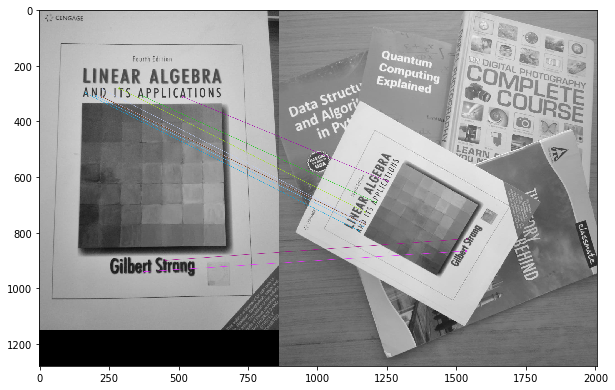

(<matplotlib.image.AxesImage at 0x7f8169b33950>, None)

In [9]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3),plt.show()

## <font style = "color:rgb(50,120,229)"> What is this Matcher Object?</font>

The result of `matches = bf.match(des1,des2)` line is a list of `DMatch` objects. This `DMatch` object has following attributes:

- `DMatch.distance` - Distance between descriptors. The lower, the better it is.
- `DMatch.trainIdx` - Index of the descriptor in train descriptors
- `DMatch.queryIdx` - Index of the descriptor in query descriptors
- `DMatch.imgIdx` - Index of the train image.

# <font style="color:rgb(50,120,229)">Descriptor Matcher </font>

The second matcher is the [**descriptorMatcher**](https://docs.opencv.org/4.1.0/db/d39/classcv_1_1DescriptorMatcher.html) class. It is similar in functionality to the BFMatcher class. 

### <font style="color:rgb(8,133,37)">Function Syntax </font>
#### <font style = "color:rgb(8,133,37)">1. Create Matcher object </font>

```python
matcher	=	cv.DescriptorMatcher_create( matcherType	)
```
It takes 1 argument. 

- `matcherType` - Matcher type to be specified. Supported types - BruteForce (it uses L2 ) BruteForce-L1, BruteForce-Hamming, BruteForce-Hamming(2), FlannBased.

#### <font style = "color:rgb(8,133,37)">2. Match Features</font>
Same as BFMatcher

#### <font style = "color:rgb(8,133,37)">3. Drawing Matches </font>
Same as BFMatcher

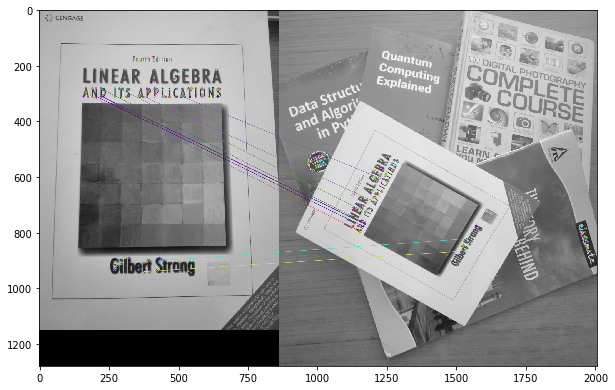

(<matplotlib.image.AxesImage at 0x7f8169ac6110>, None)

In [10]:
# create Descriptor Matcher object
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
# Match descriptors.
matches = matcher.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None)

plt.imshow(img3),plt.show()

# <font style = "color:rgb(50,120,229)">FLANN based Matcher </font>

FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works faster than BFMatcher for large datasets. 

#### <font style = "color:rgb(8,133,37)">Specify algorithm parameters</font>
For FLANN based matcher, we need to specify the algorithm to be used, its related parameters etc. The parameters are 

- `IndexParams`. - Specifies the algorithm to be used

    e.g. For algorithms like SIFT, SURF etc. you can pass following:

```python
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
```

    For ORB, you can pass the following :
    
```python
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6,
                   key_size = 12,
                   multi_probe_level = 1)
```

- `SearchParams`. It specifies the number of times the trees in the index should be recursively traversed. Higher values gives better precision, but also takes more time. If you want to change the value, pass `search_params = dict(checks=100)`.


In [11]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

In [12]:
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [13]:
matches = flann.knnMatch(np.float32(des1),np.float32(des2),k=2)

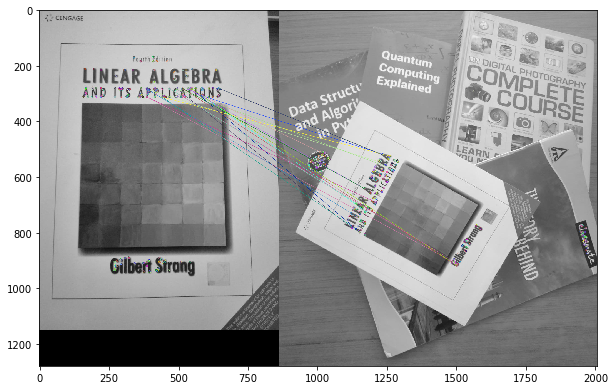

In [14]:
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches[:10],None)

plt.imshow(img3)
plt.show()

Try to use the time function to check the execution times of the algorithms